# 5.11 Final Project Assignment
## Yihnew Eshetu (yte9pc), Nathan England (nle4bz), and Karyne Williams (kw7me)

At this point in the course, you should be training and evaluating models. Please create a Jupyter Notebook containing a concise summary of your dataset (described in submission instructions).

- At a minimum, the file should include a summary containing:
- Number of records
- Number of columns
- Statistical summary of response variable
- Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
- Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
- Include up to five helpful graphs

In [55]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import stddev

import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## Yellow Cab

In [87]:
location = "/home/yte9pc/Project/Yellow_Cab/"

files = sorted(glob.glob(location + '*.csv'))

summ = 0
for idx,f in enumerate(files):
    df = spark.read.csv(f, header = True)
    
    summ += df.count()
    print(f, df.count(), summ)
    if idx == 0:
        data = df
    else:
        data = data.union(df)

/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-01.csv 7667792 7667792
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-02.csv 7019375 14687167
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-03.csv 7667526 22354693
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-04.csv 7433139 29787832
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-05.csv 7565261 37353093
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-06.csv 2171886 39524979
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-07.csv 2130329 41655308
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-08.csv 6073357 47728665
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-09.csv 6567788 54296453
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-10.csv 7213891 61510344
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-11.csv 6878111 68388455
/home/yte9pc/Project/Yellow_Cab/yellow_tripdata_2019-12.csv 6896317 75284772


In [88]:
data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)



In [89]:
data = data.withColumn("tpep_pickup_datetime", data["tpep_pickup_datetime"].cast(TimestampType()))\
    .withColumn("tpep_dropoff_datetime", data["tpep_dropoff_datetime"].cast(TimestampType()))\
    .withColumn("passenger_count", data["passenger_count"].cast(IntegerType()))\
    .withColumn("trip_distance", data["trip_distance"].cast(FloatType()))\
    .withColumn("fare_amount", data["fare_amount"].cast(FloatType()))\
    .withColumn("extra", data["extra"].cast(FloatType()))\
    .withColumn("mta_tax", data["mta_tax"].cast(FloatType()))\
    .withColumn("tip_amount", data["tip_amount"].cast(FloatType()))\
    .withColumn("tolls_amount", data["tolls_amount"].cast(FloatType()))\
    .withColumn("improvement_surcharge", data["improvement_surcharge"].cast(FloatType()))\
    .withColumn("total_amount", data["total_amount"].cast(FloatType()))\
    .withColumn("congestion_surcharge", data["congestion_surcharge"].cast(FloatType()))

data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- congestion_surcharge: float (nullable = true)



## Count of rows and columns

In [88]:
print('Count of rows: {0}'.format(data.count()))
print('Count of columns: {0}'.format(len(data.columns)))

Count of rows: 75284772
Count of columns: 18


## Statistical summary of response variables
- Possible response variable
    - Payment Type
    - Tip Amount

In [42]:
def percentage(column):
    count_level = data.groupby(column).count()
    count_level_per = count_level.withColumn('percentage', count_level['count']/ float(data.count())).orderBy(F.col(column))
    
    return count_level_per

In [46]:
def bar(df, x, y):
    labels = df.toPandas()[x]
    count = df.toPandas()[y]
    ind = [x for x, _ in enumerate(labels)]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'blue', 'lightskyblue', 'green']

    plt.figure(figsize=(10,8))
    plt.bar(ind, count, width=0.8, label='count', color=colors)

    plt.xticks(ind, labels)
    plt.ylabel(y)
    plt.xlabel('Count')
    plt.show()

def hist(df, x):
    values = df.toPandas()[x]
    bins = np.arange(0, 100, 5.0)

    plt.figure(figsize=(10,8))
    # the histogram of the data
    plt.hist(values, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(values) + 100. / values.size)

    plt.xlabel(x)
    plt.ylabel('count')
    plt.xticks(bins)
    plt.show()

In [9]:
paymentType = percentage('payment_type')
paymentType.show()

+------------+--------+--------------------+
|payment_type|   count|          percentage|
+------------+--------+--------------------+
|        null|  212644|0.002824528710799...|
|           1|54123093|  0.7189115615572297|
|           2|20386696|   0.270794417760872|
|           3|  396858|0.005271424611606...|
|           4|  165478|0.002198027510795...|
|           5|       3| 3.98486960948756E-8|
+------------+--------+--------------------+



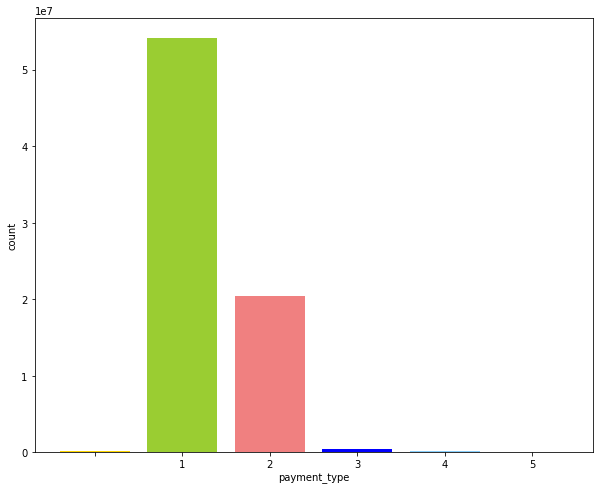

In [33]:
bar(paymentType, 'payment_type', 'count')

In [6]:
tip_amount = data.select('tip_amount')
tip_amount.summary().show()

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|          75284769|
|   mean|2.1890400254703284|
| stddev| 16.54576610173628|
|    min|            -200.8|
|    25%|               0.0|
|    50%|              1.86|
|    75%|              2.95|
|    max|         141492.02|
+-------+------------------+



In [25]:
filtertip = tip_amount.filter((tip_amount.tip_amount >= 0) & (tip_amount.tip_amount < 150))

In [26]:
hists = filtertip.select('tip_amount').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 0, 'Tip Amount')

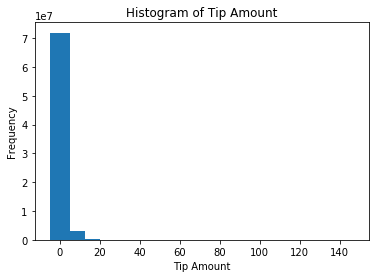

In [30]:
data_hist = {
    'bins': hists[0][:-1],
    'freq': hists[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=10)
plt.title('Histogram of ' + 'Tip Amount')
plt.ylabel('Frequency')
plt.xlabel('Tip Amount')

## Statistical summary of predictor variables

In [176]:
categorical = [c for c in data.columns if dict(data.select(c).dtypes)[c] == 'string']
for c in data.select(categorical).columns:
    percentage(c)

+--------+--------+--------------------+
|VendorID|   count|          percentage|
+--------+--------+--------------------+
|    null|  212642|0.002824502145002179|
|       1|27100009|  0.3599666742697979|
|       2|47727077|  0.6339539289565757|
|       4|  245044|0.003254894628624...|
+--------+--------+--------------------+

+----------+--------+--------------------+
|RatecodeID|   count|          percentage|
+----------+--------+--------------------+
|      null|  212642|0.002824502145002179|
|         1|72419257|  0.9619376545365642|
|         2| 1977218|0.026263186398439248|
|         3|  169433|0.002250561375147686|
|         4|   58673|7.793475153248787E-4|
|         5|  443577|0.005891988355892...|
|         6|     489|6.495337463464723E-6|
|        99|    3483|4.626433616615057E-5|
+----------+--------+--------------------+

+------------------+--------+--------------------+
|store_and_fwd_flag|   count|          percentage|
+------------------+--------+--------------------+
|

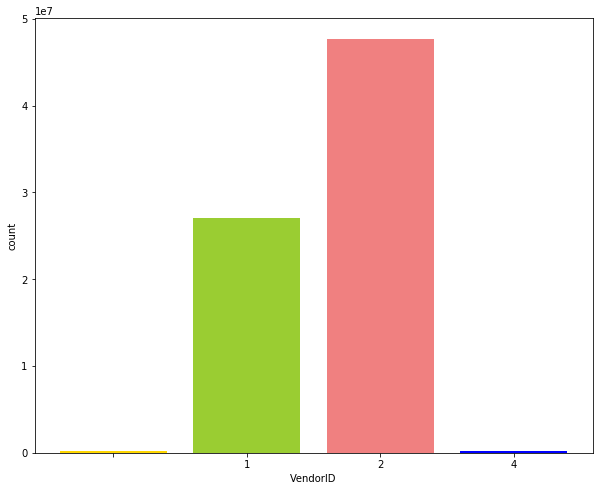

In [45]:
vendor = percentage('VendorID')
bar(vendor, 'VendorID', 'count')

In [179]:
numeric = list(set(df.columns) - set(categorical))
data.select(numeric).summary().show()

+-------+------------------+-------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|summary|             extra|            mta_tax|   passenger_count|improvement_surcharge|congestion_surcharge|      tolls_amount|     trip_distance|        tip_amount|       fare_amount|      total_amount|
+-------+------------------+-------------------+------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|  count|          75284769|           75284769|          75072130|             75284769|            70428788|          75284769|          75284772|          75284769|          75284769|          75284769|
|   mean|   1.0764021256393|0.49467046422089744|1.5619848537666374|   0.2986233801600075|  2.1778940963743407|0.3799363483043255|2.9900554357980926|2.1890400254703297| 13.29965

In [97]:
passenger = percentage('passenger_count')

labels = passenger.select('passenger_count').toPandas()
labels = labels['passenger_count']
sizes = passenger.select('count').toPandas()
sizes = sizes['count']

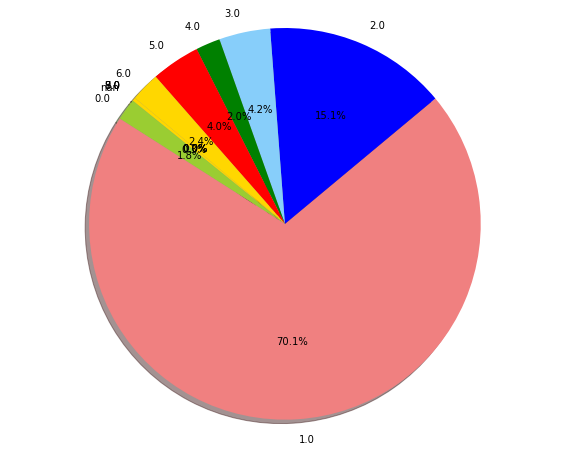

In [101]:
colors = ['gold', 'yellowgreen', 'lightcoral', 'blue', 'lightskyblue', 'green', 'red']

plt.figure(figsize=(10,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [90]:
trip = data.select('trip_distance').filter((data.trip_distance >= 0) & (data.trip_distance < 30))

In [91]:
hists_trip = trip.select('trip_distance').rdd.flatMap(lambda row: row).histogram(5)
hists_trip

([0.0,
  5.997999954223633,
  11.995999908447265,
  17.993999862670897,
  23.99199981689453,
  29.989999771118164],
 [66292700, 5580205, 2065180, 1198916, 100433])

Text(0.5, 0, 'Trip Distance')

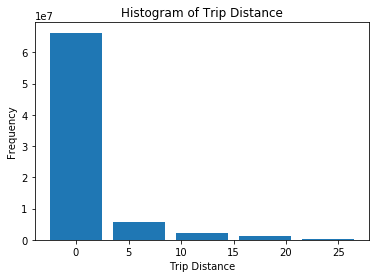

In [92]:
data_hist = {
    'bins': hists_trip[0][:-1],
    'freq': hists_trip[1]
    }
plt.bar(data_hist['bins'], data_hist['freq'], width=5)
plt.title('Histogram of ' + 'Trip Distance')
plt.ylabel('Frequency')
plt.xlabel('Trip Distance')

In [102]:
!jupyter nbconvert --to pdf masterfinalproject.ipynb

[NbConvertApp] Converting notebook masterfinalproject.ipynb to pdf
[NbConvertApp] Support files will be in masterfinalproject_files/
[NbConvertApp] Making directory ./masterfinalproject_files
[NbConvertApp] Making directory ./masterfinalproject_files
[NbConvertApp] Making directory ./masterfinalproject_files
[NbConvertApp] Making directory ./masterfinalproject_files
[NbConvertApp] Making directory ./masterfinalproject_files
[NbConvertApp] Writing 57369 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 113487 bytes to masterfinalproject.pdf
